In [8]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import pandas as pd
import cvxpy as cvx
import cvxopt 
import sklearn.feature_selection as fs
from sklearn.model_selection import KFold

%config InlineBackend.figure_format = 'retina'

In [9]:
%run numpy_nn.py

### Data

In [10]:
np.random.seed(30)

n_features = 5
n_samples = 400

X = np.random.randn(n_samples, n_features)

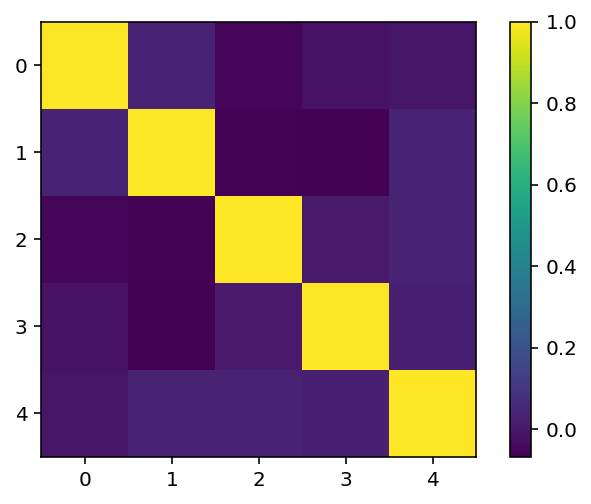

In [11]:
plt.imshow(np.corrcoef(X.T))
plt.colorbar()

In [12]:
def generate_collinear_features(n, X):
    n_features = X.shape[1]
    X_new = np.zeros([X.shape[0], n])
    for i in range(n):
        n_cols = max(2, np.random.randint(n_features / 3) + 1)
        col_idxs = np.random.choice(np.arange(n_features), int(n_cols), replace=False)
        coef = np.random.rand(n_cols)
        coef /= np.sqrt(np.sum(coef ** 2))
        X_new[:, i] = X[:, col_idxs].dot(coef) 
    return X_new

X_col = generate_collinear_features(45, X)

In [13]:
X = np.hstack([X, X_col])

n_samples, n_features = X.shape

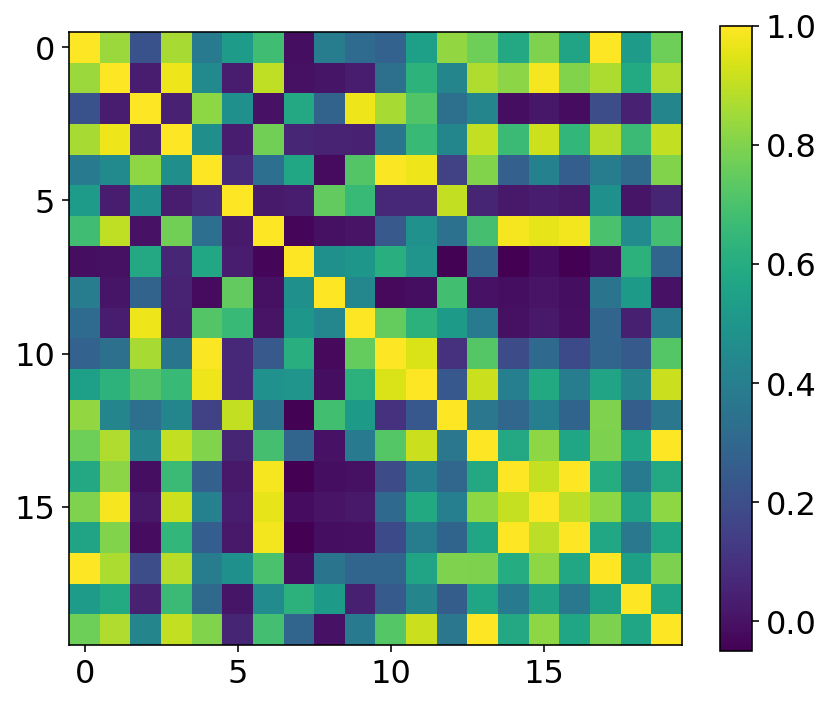

In [14]:
plt.figure(figsize=(6, 5))
plt.imshow(np.corrcoef(X.T)[10:30, 10:30])
plt.xticks((0, 5, 10, 15), fontsize=16)
plt.yticks((0, 5, 10, 15), fontsize=16)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16) 
plt.tight_layout()
plt.savefig('figs/corr.eps', format='eps')
plt.show()

In [15]:
n_hidden = 30
n_out = 2

W1_true = np.random.randn(n_hidden, n_features)
W2_true = np.random.randn(n_out, n_hidden)
b1_true = np.random.randn(n_hidden)
b2_true = np.random.randn(n_out)

mask1 = (np.random.randn(*W1_true.shape) > 0.5)
mask2 = (np.random.randn(*W2_true.shape) > 0.5)

W1_true *= mask1
W2_true *= mask2

layer1 = Linear(n_features, n_hidden, W_init=W1_true, b_init=b1_true)
layer2 = Linear(n_hidden, n_out, W_init=W2_true, b_init=b2_true)
act2 = SoftMax()
act1 = LeakyReLU(slope=0.1)

y = act2.forward(layer2.forward(act1.forward(layer1.forward(X)))) + np.random.randn(n_samples, n_out) * .5
y = (y > 0.5).astype(float)

### Neural network optimization

In [16]:
def sgd_momentum(x, dx, config, state):
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x, dx): 
        for cur_x, cur_dx in zip(cur_layer_x, cur_layer_dx):
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, 
                   out = cur_old_grad)
            cur_x -= cur_old_grad
            i += 1
            
def nesterov(x, dx, config, state):
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x, dx): 
        for cur_x, cur_dx in zip(cur_layer_x, cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, 
                   out = cur_old_grad)
            
            cur_x -= cur_old_grad * config['momentum'] + config['learning_rate'] * cur_dx
            i += 1
            
def adam(x, dx, config, state):
    state.setdefault('old_grad', {})
    state.setdefault('old_squared_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x, dx): 
        for cur_x, cur_dx in zip(cur_layer_x, cur_layer_dx):
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            cur_old_squared_grad = state['old_squared_grad'].setdefault(i, 
                                                                        np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, (1 - config['momentum']) * cur_dx, 
                   out = cur_old_grad)
            
            np.add(config['squared_momentum'] * cur_old_squared_grad, 
                   (1 - config['squared_momentum']) * cur_dx ** 2,
                   out = cur_old_squared_grad)
            
            cog = cur_old_grad / (1 - config['momentum'])
            cosg = cur_old_squared_grad / (1 - config['squared_momentum'])
            
            cur_x -= config['learning_rate'] * np.divide(cog, np.sqrt(cosg) + config['eps'])
            i += 1

In [17]:
# batch generator
def get_batches(dataset, batch_size, shuffle=True):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    if shuffle:
        np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [18]:
def train(net, X_train, y_train, X_test, y_test, batch_size, n_epoch, optimizer_method, criterion,
          optimizer_config, optimizer_state, weight_decay=False, filename='orig_net'):
    loss_history = []
    loss_history_epoch = []
    train_acc = []
    test_acc = []
    
    for i in range(n_epoch):
        loss_history_epoch.append(0.)
        if weight_decay and i % 20 == 0:
            optimizer_config['learning_rate'] *= 0.5
            
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights

            optimizer_method(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)

            loss_history.append(loss)
            loss_history_epoch[-1] += loss
        
        pred_train = net.forward(X_train).argmax(axis=1)
        train_acc.append(float(np.sum(y_train[:, 1] == pred_train)) / len(y_train))
        
        pred_test = net.forward(X_test).argmax(axis=1)
        test_acc.append(float(np.sum(y_test[:, 1] == pred_test)) / len(y_test))

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(14, 4))
        plt.subplot(1, 2, 1)
        plt.xlabel("epochs", fontsize=18)
        plt.ylabel("loss", fontsize=18 )
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.plot(loss_history_epoch, 'b')
        plt.subplot(1, 2, 2)
        plt.xlabel("epochs", fontsize=18)
        plt.ylabel("accuracy", fontsize=18)
        plt.plot(train_acc, 'r', label='train')
        plt.plot(test_acc, 'g', label='test')
        plt.legend(fontsize=18)
        plt.xticks(fontsize=18)
        plt.yticks([0.6, 0.7, 0.8, 0.9], fontsize=18)
        plt.subplots_adjust()
        plt.tight_layout()
        plt.savefig('figs/{}.eps'.format(filename), format='eps')
        plt.show()

        print('Current loss: %f' % loss)
    return loss_history, train_acc, test_acc

### Toy exampe

### Synthetic data

In [15]:
X_train = X[:int(0.75 * n_samples), :]
y_train = y[:int(0.75 * n_samples)]
X_test = X[int(0.75 * n_samples):, :]
y_test = y[int(0.75 * n_samples):]
print(X_train.shape, X_test.shape)

(300, 50) (100, 50)


In [16]:
net = Sequential()
net.add(Linear(n_features, n_hidden))
net.add(LeakyReLU(slope=0.1))
net.add(Linear(n_hidden, 2))
net.add(SoftMax())

criterion = ClassNLLCriterion()

print(net)

Linear(50 -> 30)
LeakyReLU(slope=0.100)
Linear(30 -> 2)
SoftMax



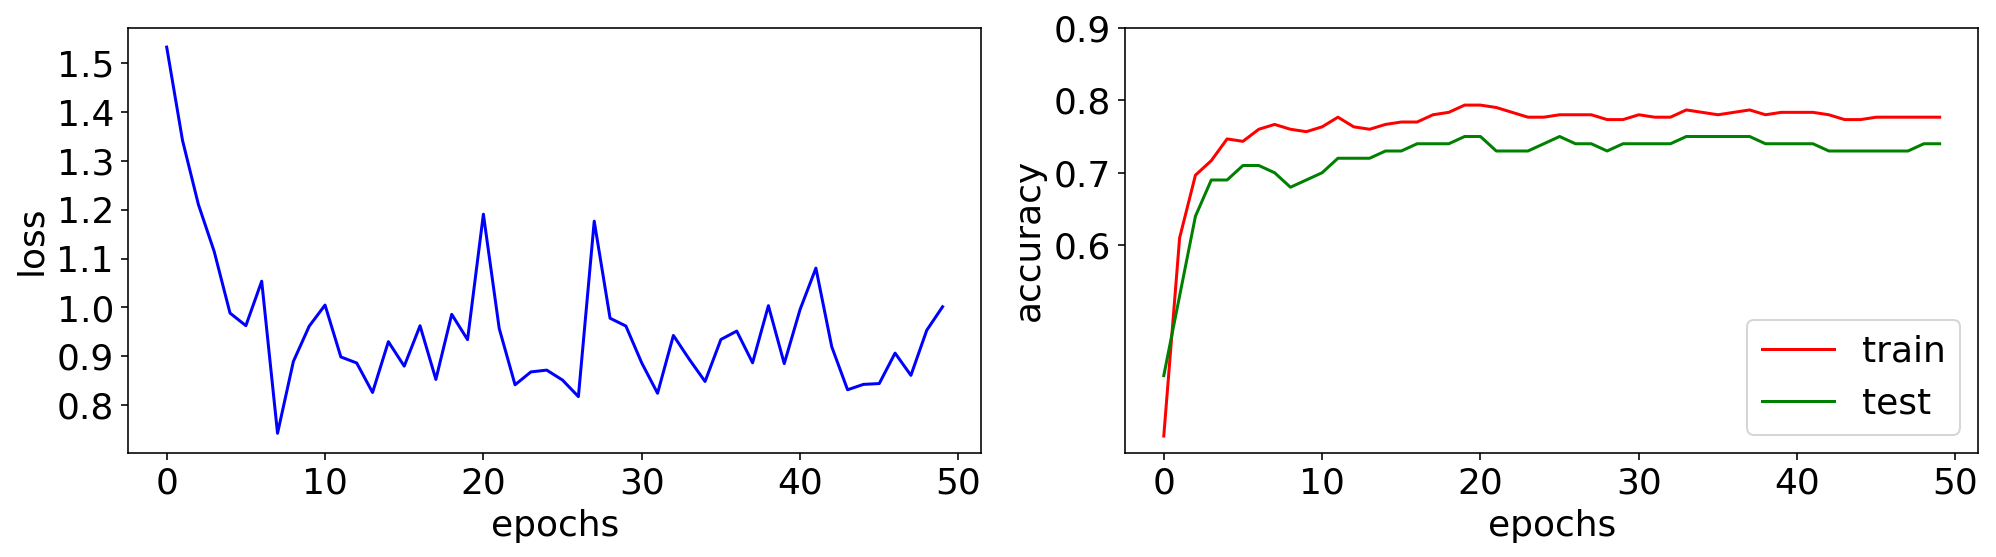

Current loss: 0.572588


In [17]:
results = {}

# Iptimizer params
optimizer_config = {'learning_rate' : 0.05, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 50
batch_size = 256

loss_history = train(net, X_train, y_train, X_test, y_test, batch_size, n_epoch, sgd_momentum, criterion,
                     optimizer_config, optimizer_state, weight_decay=True)

train_acc = np.sum(y_train[:, 1] == (net.forward(X_train)[:, 1] > 0.5)) / len(y_train)
test_acc = np.sum(y_test[:, 1] == (net.forward(X_test)[:, 1] > 0.5)) / len(y_test)

results['original'] = [train_acc, test_acc]

In [18]:
W1 = net.modules[0].W
W2 = net.modules[2].W
b1 = net.modules[0].b
b2 = net.modules[2].b

print(np.sqrt(np.sum(W1 - W1_true) ** 2) / np.sqrt(np.sum(W1_true) ** 2))
print(np.sqrt(np.sum(W2 - W2_true) ** 2) / np.sqrt(np.sum(W2_true) ** 2))

0.747613083415
0.998683306186


### Quadratic programming

In [19]:
def create_opt_problem(X, y, sim, rel, verbose=False):
    """
    % Function generates matrix Q and vector b
    % which represent feature similarities and feature relevances
    %
    % Input:
    % X - [m, n] - design matrix
    % y - [m, 1] - target vector
    % sim - string - indicator of the way to compute feature similarities,
    % support values are 'correl' and 'mi'
    % rel - string - indicator of the way to compute feature significance,
    % support values are 'correl', 'mi' and 'signif'
    %
    % Output:
    % Q - [n ,n] - matrix of features similarities
    % b - [n, 1] - vector of feature relevances
    """
    
    if verbose == True:
        print("Constructing the problem...")
        print('Similarity measure: %s, feature relevance measure: %s' % (sim, rel))
    if len(y.shape) == 1:
        y_mat = y[:, np.newaxis]
    else:
        y_mat = y[:]
        
    cor = np.corrcoef(np.hstack([X, y_mat]).T)
    
    if sim == 'correl':
        Q = cor[:-1, :-1]
    else:
        print("Wrong similarity measure")
        
    if rel == 'correl':
        b = cor[:-1, [-1]]
    elif rel == 'log-reg':
        lr = LogisticRegression()
        b = np.zeros((X.shape[1], 1))
        for i in range(X.shape[1]):
            lr.fit(X[:, [i]], y)
            y_pred = lr.predict(X[:, [i]])
            b[i] = np.corrcoef(y_pred, y)[0, 1]
        b = np.nan_to_num(b)
    else:
        print("Wrong relevance measure")
        
    if verbose == True:
        print("Problem has been constructed.")
    return Q, np.abs(b)


def solve_opt_problem(Q, b, verbose=False):
    """
     Function solves the quadratic optimization problem stated to select
     significance and noncollinear features

     Input:
     Q - [n, n] - matrix of features similarities
     b - [n, 1] - vector of feature relevances

     Output:
     x - [n, 1] - solution of the quadratic optimization problem
    """
    
    n = Q.shape[0]
    x = cvx.Variable(n)
    
    objective = cvx.Minimize(cvx.quad_form(x, Q) - 1. * b.T * x)
    constraints = [x >= 0, x <= 1]
    prob = cvx.Problem(objective, constraints)
    
    if verbose == True:
        print("Solving the QP problem...")
    
    prob.solve()
    
    if verbose == True:
        print("The problem has been solved!")
        print("Problem status:", prob.status)
        print

    return np.array(x.value).flatten()
    
def quadratic_programming(X, y, sim='correl', rel='correl', verbose=False):
    Q, b = create_opt_problem(X, y, sim, rel, verbose)
    print
    qp_score = solve_opt_problem(Q, b, verbose)
    return qp_score

In [20]:
z = quadratic_programming(X_train, y_train[:, 1], verbose=True)

Constructing the problem...
Similarity measure: correl, feature relevance measure: correl
Problem has been constructed.
Solving the QP problem...
The problem has been solved!
Problem status: optimal


In [21]:
Q, b = create_opt_problem(X_train, y_train[:, 1], 'correl', 'correl')

In [22]:
z[:30]

array([  1.80045035e-02,   1.06062636e-10,   6.09758131e-03,
         1.49553770e-02,   6.64679516e-02,   1.44470514e-02,
         8.29258480e-11,   1.29052674e-02,   1.71564883e-10,
         1.18444859e-10,   1.54600685e-02,   1.24846023e-02,
         9.17216632e-11,   3.71977441e-02,   9.91851169e-11,
         6.68800325e-10,   6.31023491e-03,   1.37434575e-10,
         9.76110002e-03,   1.04945787e-10,   9.23289652e-11,
         1.18630366e-10,   1.23749155e-02,   2.14553768e-10,
         5.67789589e-03,   8.76778251e-03,   5.60549393e-03,
         1.63121721e-02,   1.37828975e-02,   2.13694169e-10])

### Neural Networks QPFS

In [71]:
def create_opt_problem(net, y_train, sim='corr', rel='mi', pd=True):
    W1 = net.modules[0].W
    W2 = net.modules[2].W
    
    n_hid, n_in = W1.shape
    n_out = W2.shape[0]
    inp = net.layer_outputs[0]
    out = net.layer_outputs[-1]
    hid = net.layer_outputs[2]
    if sim == 'corr':
        cor1 = np.abs(np.corrcoef(inp.T))
        cor2 = np.abs(np.corrcoef(hid.T))
    elif sim == 'mi':
        cor1 = np.zeros([n_in, n_in])
        cor2 = np.zeros([n_hid, n_hid])
        for j in range(n_in):
            cor1[:, j] = fs.mutual_info_regression(inp, inp[:, j])
        for j in range(n_hid):
            cor2[:, j] = fs.mutual_info_regression(hid, hid[:, j])
    
    if pd:
        lamb_min1 = sc.linalg.eigh(cor1)[0][0]
        if lamb_min1 < 0:
            cor1 = cor1 - lamb_min1 * np.eye(*cor1.shape)
        lamb_min2 = sc.linalg.eigh(cor2)[0][0]
        if lamb_min2 < 0:
            cor2 = cor2 - lamb_min2 * np.eye(*cor2.shape)
    
    Q1 = cor1.repeat(n_hid, axis=1).repeat(n_hid, axis=0)
    Q2 = cor2.repeat(n_out, axis=1).repeat(n_out, axis=0)
    
    J1 = np.zeros([inp.shape[0], n_hid * n_in])
    J2 = np.zeros([inp.shape[0], n_out * n_hid])
    for i, (x_batch, y_batch) in enumerate(get_batches((inp, y_train), batch_size=1, shuffle=False)):
        pred = net.forward(x_batch)
        loss = criterion.forward(pred, y_batch)

        dp = criterion.backward(pred, y_batch)
        net.backward(x_batch, dp)
        J2[i, :] = net.modules[2].gradW.ravel('F')
        J1[i, :] = net.modules[0].gradW.ravel('F')
        
    b1 = np.zeros([n_hid * n_in, 1])
    b2 = np.zeros([n_out * n_hid, 1])
    if rel == 'correl':
        for j in range(n_hid * n_in):
            b1[j] = np.corrcoef(J1[:, j], y_train[:, 1])[0, 1]
        for j in range(n_out * n_hid):
            b2[j] = np.corrcoef(J2[:, j], y_train[:, 1])[0, 1]
    elif rel == 'mi':
        b1 = fs.mutual_info_regression(J1, y_train[:, 1])
        b2 = fs.mutual_info_regression(J2, y_train[:, 1])
    return Q1, Q2, b1, b2, lamb_min1, lamb_min2


def solve_opt_problem(Q, b, alpha, verbose=False):
    """
     Function solves the quadratic optimization problem stated to select
     significance and noncollinear features

     Input:
     Q - [n, n] - matrix of features similarities
     b - [n, 1] - vector of feature relevances

     Output:
     x - [n, 1] - solution of the quadratic optimization problem
    """
    
    n = Q.shape[0]
    x = cvx.Variable(n)
    
    objective = cvx.Minimize(cvx.quad_form(x, Q) - alpha * b.T * x)
    constraints = [x >= 0, x <= 1]
    prob = cvx.Problem(objective, constraints)
    
    if verbose == True:
        print("Solving the QP problem...")
    
    prob.solve(ignore_dcp=True)
    
    if verbose == True:
        print("The problem has been solved!")
        print("Problem status:", prob.status)
        print

    return np.array(x.value).flatten()


def quadratic_programming(net, X_train, y_train, verbose=False):
    net.forward(X_train)
    Q, b = create_opt_problem(net)
    alpha = alpha_opt(Q, b)
    qp_score = solve_opt_problem(Q, b, alpha, verbose)
    return qp_score


def alpha_opt(Q, b):
    return Q.mean() / (Q.mean() + b.mean())


# def custom_alpha_opt(Q, b, lambda_min=0):
#     n = len(b)
#     return (Q.mean() + np.abs(lambda_min) / n) / (Q.mean() + b.mean() + np.abs(lambda_min) / n)


def custom_alpha_opt(Q, b, k=0.3):
    n = len(b)
    return Q.mean() * n * k / b.mean()

$$
    q N^2 z^2 = \alpha b z N
$$

$$
    \alpha = \frac{q N z}{b}
$$

In [98]:
net.forward(X_train)
Q1, Q2, b1, b2, lamb_min1, lamb_min2 = create_opt_problem(net, y_train)
print(Q1.shape, Q2.shape, b1.shape, b2.shape)

(1500, 1500) (60, 60) (1500,) (60,)


In [99]:
alpha1 = 2 * alpha_opt(Q1, b1) / (1 - alpha_opt(Q1, b1))
alpha2 = 2 * alpha_opt(Q2, b2) / (1 - alpha_opt(Q2, b2))
print(alpha1, alpha2)

6.03973717736 2.26623001583


In [100]:
alpha1 = custom_alpha_opt(Q1, b1, k=0.05)
alpha2 = custom_alpha_opt(Q2, b2, k=0.05)
print(alpha1, alpha2)

226.490144151 3.39934502374


In [101]:
z1 = solve_opt_problem(Q1, b1, alpha1, True)
print()
z2 = solve_opt_problem(Q2, b2, alpha2, True)

Solving the QP problem...
The problem has been solved!
Problem status: optimal

Solving the QP problem...
The problem has been solved!
Problem status: optimal


In [102]:
z1.sum(), z2.sum()

(77.337011355864945, 2.1958949257284899)

In [103]:
for z_ in sorted(z1)[::-1][:20]:
    print("{:.7f}".format(z_))

1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000


In [104]:
threshold = 1e-10
n_params1, n_params2 = np.sum(z1 > threshold), np.sum(z2 > threshold)
n_params1, n_params2

(98, 20)

In [105]:
mask_pred1 = (z1 > threshold).reshape([n_features, n_hidden]).T
mask_pred2 = (z2 > threshold).reshape([n_hidden, 2]).T

In [106]:
mask_pred1 = (z1 > threshold).reshape([n_features, n_hidden]).T
mask_pred2 = (z2 > threshold).reshape([n_hidden, 2]).T

net_qpfs = Sequential()
net_qpfs.add(Linear(n_features, n_hidden, W_init=net.modules[0].W, b_init=net.modules[0].b, mask=mask_pred1))
net_qpfs.add(LeakyReLU(slope=0.1))
net_qpfs.add(Linear(n_hidden, 2, W_init=net.modules[2].W, b_init=net.modules[2].b, mask=mask_pred2))
net_qpfs.add(SoftMax())

criterion = ClassNLLCriterion()

print(net_qpfs)

Linear(50 -> 30)
LeakyReLU(slope=0.100)
Linear(30 -> 2)
SoftMax



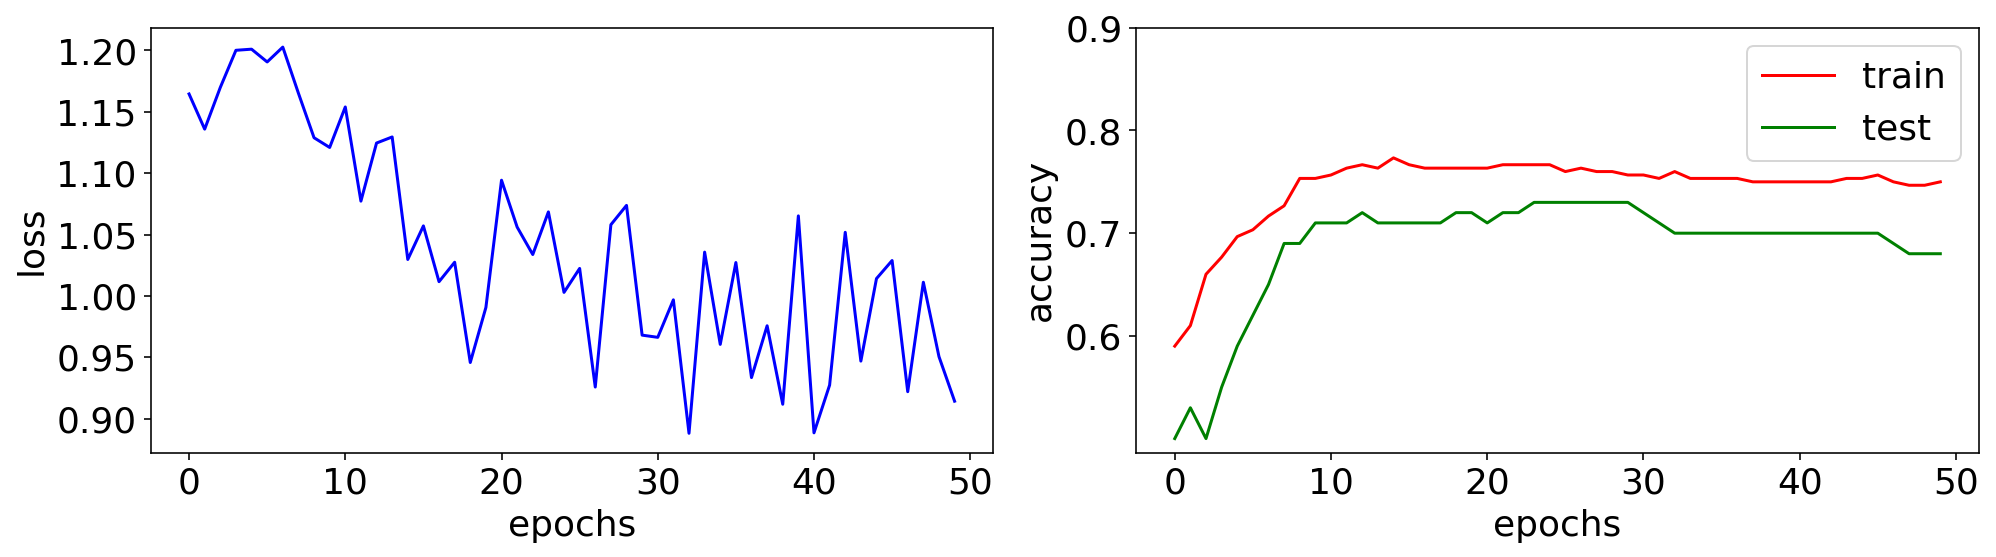

Current loss: 0.402876


In [107]:
# Iptimizer params
optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 50
batch_size = 256

loss_history = train(net_qpfs, X_train, y_train, X_test, y_test, 
                     batch_size, n_epoch, sgd_momentum, criterion,
                     optimizer_config, optimizer_state, 
                     weight_decay=True, filename='reduced_net')

 
train_acc = np.sum(y_train[:, 1] == (net_qpfs.forward(X_train)[:, 1] > 0.5)) / len(y_train)
test_acc = np.sum(y_test[:, 1] == (net_qpfs.forward(X_test)[:, 1] > 0.5)) / len(y_test)

results['qpfs'] = [train_acc, test_acc]

In [108]:
W1 = net_qpfs.modules[0].W
W2 = net_qpfs.modules[2].W
b1 = net_qpfs.modules[0].b
b2 = net_qpfs.modules[2].b

print(np.sqrt(np.sum(W1 - W1_true) ** 2) / np.sqrt(np.sum(W1_true) ** 2))
print(np.sqrt(np.sum(W2 - W2_true) ** 2) / np.sqrt(np.sum(W2_true) ** 2))

1.23831516874
0.886947203915


In [109]:
print(net.modules[0].W.shape, net.modules[2].W.shape)
print(np.prod(net.modules[0].W.shape) + np.prod(net.modules[2].W.shape))

print(np.sum(mask_pred1), np.sum(mask_pred2))
print(np.sum(mask_pred1) + np.sum(mask_pred2))

(30, 50) (2, 30)
1560
98 20
118


In [110]:
idx1 = np.random.choice(np.arange(np.prod(W1.shape)), n_params1, replace=False)
idx2 = np.random.choice(np.arange(np.prod(W2.shape)), n_params2, replace=False)

mask_pred1 = np.zeros([n_hidden, n_features])
mask_pred2 = np.zeros([2, n_hidden])

for idx in idx1:
    mask_pred1[idx // n_features, idx % n_features] = 1
    
for idx in idx2:
    mask_pred2[idx // n_hidden, idx % n_hidden] = 1

In [9]:
net_rand = Sequential()
net_rand.add(Linear(n_features, n_hidden, W_init=net.modules[0].W, b_init=net.modules[0].b, mask=mask_pred1))
net_rand.add(LeakyReLU(slope=0.1))
net_rand.add(Linear(n_hidden, 2, W_init=net.modules[2].W, b_init=net.modules[2].b, mask=mask_pred2))
net_rand.add(SoftMax())

criterion = ClassNLLCriterion()

print(net_rand)

NameError: name 'net' is not defined

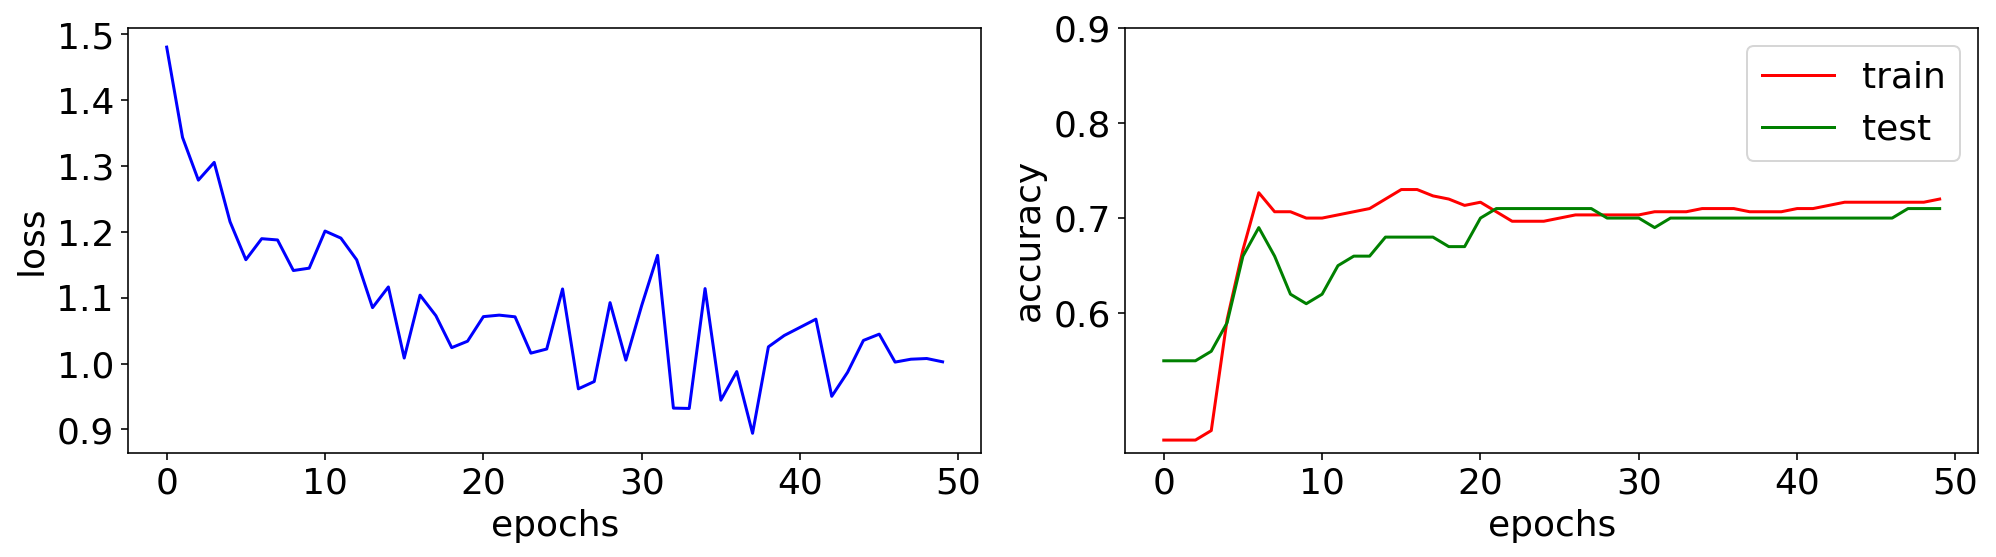

Current loss: 0.510443


In [112]:
# Iptimizer params
optimizer_config = {'learning_rate' : 0.05, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 50
batch_size = 256

loss_history = train(net_rand, X_train, y_train, X_test, y_test, 
                     batch_size, n_epoch, sgd_momentum, criterion,
                     optimizer_config, optimizer_state, 
                     weight_decay=True, filename='reduced_net')

train_acc = np.sum(y_train[:, 1] == (net_rand.forward(X_train)[:, 1] > 0.5)) / len(y_train)
test_acc = np.sum(y_test[:, 1] == (net_rand.forward(X_test)[:, 1] > 0.5)) / len(y_test)

results['random'] = [train_acc, test_acc]

In [113]:
results

{'original': [0.77666666666666662, 0.73999999999999999],
 'qpfs': [0.75, 0.68000000000000005],
 'random': [0.71999999999999997, 0.70999999999999996]}

In [26]:
a = np.array([[1, 2], [3, -2], [5, 0]])
b = np.array([[3, -2], [1, 2], [5, 0]])
np.corrcoef(np.hstack(a, b)

array([[ 1., -1., -1., -1.,  1., -1.],
       [-1.,  1.,  1.,  1., -1.,  1.],
       [-1.,  1.,  1.,  1., -1.,  1.],
       [-1.,  1.,  1.,  1., -1.,  1.],
       [ 1., -1., -1., -1.,  1., -1.],
       [-1.,  1.,  1.,  1., -1.,  1.]])